# Process the lupus data

- Filter and subset by cell type
- Create pseudobulks for matrix eQTL

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline
import qvalue

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path  = '/data_volume/memento/lupus/'

### Read the lupus data

In [ ]:
pos_asian = pd.read_csv(data_path + 'mateqtl_input/asian/cm_cg.genos', sep='\t', index_col=0)
pos_eur = pd.read_csv(data_path + 'mateqtl_input/eur/cm.genos', sep='\t', index_col=0)

In [ ]:
print(pos_asian.shape, pos_eur.shape)

In [ ]:
pos_asian = pos_asian[~pos_asian.index.duplicated(keep='first')]
pos_eur = pos_eur[~pos_eur.index.duplicated(keep='first')]

In [ ]:
print(pos_asian.shape, pos_eur.shape)

In [ ]:
common_snps = list(set(pos_asian.index) & set(pos_eur.index))

In [ ]:
pos_asian = pos_asian.loc[common_snps]
pos_eur = pos_eur.loc[common_snps]

In [ ]:
pos_asian.to_csv(data_path + 'mateqtl_input/asian_genos.tsv', sep='\t')
pos_eur.to_csv(data_path + 'mateqtl_input/eur_genos.tsv', sep='\t')

In [ ]:
pos_asian.shape

In [10]:
pos_eur.shape

(3285470, 91)

In [4]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts.h5ad')

In [7]:
adata.obs.groupby(['ind_cov', 'cg_cov']).size().mean()

440.15186346220827

In [5]:
adata.obs.ind_cov.value_counts().mean()

4841.6704980842915

In [12]:
adata.obs.cg_cov.value_counts()

T4        380477
cM        307429
T8        248927
B         151570
NK         92554
ncM        48800
cDC        18203
Prolif      8265
pDC         5233
PB          1411
Progen       807
Name: cg_cov, dtype: int64

In [22]:
asian_snpspos = pd.read_csv('/data_volume/memento/lupus/mateqtl_input/asian/cm_cg.snpspos.txt', sep='\t', index_col=0)
eur_snpspos = pd.read_csv('/data_volume/memento/lupus/mateqtl_input/eur/cm_cg.snpspos.txt', sep='\t', index_col=0)

In [24]:
asian_snpspos.loc[common_snps]\
    .to_csv('/data_volume/memento/lupus/full_analysis/mateqtl/inputs/asian_snpspos.txt', sep='\t')
eur_snpspos.loc[common_snps]\
    .to_csv('/data_volume/memento/lupus/full_analysis/mateqtl/inputs/eur_snpspos.txt', sep='\t')

### Read cell types from 1K1K results

In [13]:
onek1k_pos = pd.read_csv('1k1k_snps_chrpos.txt', header=None).iloc[:,0].tolist()
onek1k_info = pd.read_csv('1k1k_snp_info.txt', sep='\t', header=None).iloc[:,:3]
onek1k_info.columns = ['chr', 'pos', 'name']
onek1k_info['rsid'] = onek1k_info['chr'].astype(str) + ':' + onek1k_info['pos'].astype(str)

In [14]:
onek_replication = pd.read_csv(data_path + 'OneK1K_eqtls_for_replication.txt', sep='\t')#.query('cell_type == "Mono_C"')

In [15]:
onek_replication = onek_replication.merge(onek1k_info, left_on='SNP_rsID', right_on='name')#.query('cell_type == "Mono_C"')

In [34]:
ct_converter = {
    'CD4_Naïve_CM':'T4',
    'CD4_EM_TEMRA':'T4',
    'CD4_SOX4':'T4',
    'CD8_EM_TEMRA':'T8',
    'CD8_Naïve_CM':'T8',
    'CD8_S100B':'T8',
    'Mono_C':'cM',
    'Mono_NC':'ncM',
    'NK':'NK',
    'NK_recruiting':'NK',
    'B_Imm_Naïve':'B',
    'BMem':'B',
    'Plasma':'B'
}

In [35]:
cts = list(set([y for x,y in ct_converter.items()]))

In [36]:
cts

['T4', 'cM', 'ncM', 'T8', 'B', 'NK']

In [18]:
onek_replication = onek_replication.\
    query('rsid in @pos_asian.index.tolist() & cell_type in @ct_converter.keys() & GeneID in @adata.var.index')\
    .rename(columns={'GeneID':'gene'})

In [19]:
onek_replication['cg_cov'] = onek_replication['cell_type'].apply(lambda x: ct_converter[x])

In [20]:
onek_replication.to_csv(data_path + 'filtered_onek_eqtls.csv', index=False)

In [21]:
onek_replication.shape

(9382, 10)

### Make subsets and pseudobulks

In [22]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts.h5ad')

In [24]:
for ct in cts:
        
    subset = adata[(adata.obs['cg_cov'] == ct) & (adata.obs['ind_cov'].isin(pos_asian.columns))].copy()
    subset.write(data_path + 'single_cell/asian_{}.h5ad'.format(ct))
    asian_ind_list = pos_asian.columns.tolist()

    means = []
    for ind in asian_ind_list:
        view = subset[subset.obs.ind_cov==ind]
        if view.shape[0] == 0:
            means.append(np.log(view.X.sum(axis=0).A1+1))
        else:
            means.append(np.log(view.X.mean(axis=0).A1+1))
    pseudobulk = pd.DataFrame(np.vstack(means), columns=subset.var.index, index=asian_ind_list)
    pseudobulk.to_csv(data_path + 'pseudobulk/asian_{}.csv'.format(ct), sep='\t')
        
    subset = adata[(adata.obs['cg_cov'] == ct) & (adata.obs['ind_cov'].isin(pos_eur.columns))].copy()
    subset.write(data_path + 'single_cell/eur_{}.h5ad'.format(ct))
    eur_ind_list = pos_eur.columns.tolist()

    means = []
    for ind in eur_ind_list:
        view = subset[subset.obs.ind_cov==ind]
        if view.shape[0] == 0:
            means.append(np.log(view.X.sum(axis=0).A1+1))
        else:
            means.append(np.log(view.X.mean(axis=0).A1+1))
    pseudobulk = pd.DataFrame(np.vstack(means), columns=subset.var.index, index=eur_ind_list)
    pseudobulk.to_csv(data_path + 'pseudobulk/eur_{}.csv'.format(ct), sep='\t')
    

### Make covariate file

In [25]:
asian_cov = pd.read_csv(data_path + 'mateqtl_input/asian/cm_cg.mateqtl_cov.txt', sep='\t', index_col=0).T
eur_cov = pd.read_csv(data_path + 'mateqtl_input/eur/cm.mateqtl_cov.txt', sep='\t', index_col=0).T

In [26]:
asian_cov['batch_cov'] = 'b_'+asian_cov['batch_cov'].astype(int).astype(str)
eur_cov['batch_cov'] = 'b_'+eur_cov['batch_cov'].astype(int).astype(str)

In [ ]:
# asian_cov['pop'] = 1.0
# eur_cov['pop'] = 0.0

In [ ]:
# asian_cov = asian_cov.drop('batch_cov', axis=1)
# eur_cov = eur_cov.drop('batch_cov', axis=1)

In [ ]:
asian_cov = pd.get_dummies(asian_cov, drop_first=True)
eur_cov = pd.get_dummies(eur_cov, drop_first=True)

In [ ]:
asian_cov.T.to_csv(data_path + 'mateqtl_input/asian_mateqtl_cov.txt', sep='\t')
eur_cov.T.to_csv(data_path + 'mateqtl_input/eur_mateqtl_cov.txt', sep='\t')

### Save a filtered copy of SNPs

In [203]:
pos.loc[onek_replication['rsid'].drop_duplicates().tolist()].to_csv(data_path + 'mateqtl_input/filtered_genos.tsv', sep='\t')



In [258]:
pos_asian.loc[onek_replication['rsid'].drop_duplicates().tolist()]\
    .to_csv(data_path + 'mateqtl_input/asian_filtered_genos.tsv', sep='\t')
pos_eur.loc[onek_replication['rsid'].drop_duplicates().tolist()]\
    .to_csv(data_path + 'mateqtl_input/eur_filtered_genos.tsv', sep='\t')

In [35]:
shuffled_pos = pos.loc[onek_replication['rsid'].drop_duplicates().tolist()].copy()

In [36]:
def crazyshuffle(arr):
    x, y = arr.shape
    rows = np.indices((x,y))[0]
    cols = [np.random.permutation(y) for _ in range(x)]
    return arr[rows, cols]

In [37]:
shuffled_pos[shuffled_pos.columns] = crazyshuffle(shuffled_pos.values)

In [42]:
shuffled_pos.to_csv(data_path + 'mateqtl_input/shuffled_filtered_genos.tsv', sep='\t')

### Create gene-SNP pairs based on genomic locations

In [5]:
from pybedtools import BedTool

In [6]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/Hg19Genes.bed')

In [11]:
tss_df = enc.get_tss_window(window_size=0)
gene_df = enc.gene_locations.groupby(['symbol', 'chrom']).agg({'txStart':'min', 'txEnd':'max'}).reset_index()[['chrom', 'txStart', 'txEnd', 'symbol']]

In [13]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts.h5ad')

In [14]:
tss_df = tss_df[tss_df['symbol'].isin(adata.var.index)]
gene_df = gene_df[gene_df['symbol'].isin(adata.var.index)]

In [15]:
tss_window_bed = BedTool.from_dataframe(tss_df)
gene_window_bed = BedTool.from_dataframe(gene_df)

In [18]:
result.head(2)

,chrom,start,end,name,score,strand,thickStart,thickEnd
0,chr1,9497727,204676558,5S_rRNA,chr1,9397878,9397878,1:9397878
1,chr1,9497727,204676558,5S_rRNA,chr1,9398610,9398610,1:9398610


In [33]:
# Use whole gene
for pop in ['asian', 'eur']:
    snppos = pd.read_csv(data_path + 'mateqtl_input/{}/cm_cg.snpspos.txt'.format(pop), sep='\t')
    snppos['chrom'] = snppos['chr']
    snppos['pos_start'] = snppos['pos']
    snppos['pos_end'] = snppos['pos']
    snppos['rsid'] = snppos['snps']
    snppos = snppos[['chrom', 'pos_start', 'pos_end', 'rsid']]
    snp_bed = BedTool.from_dataframe(snppos)
    result = BedTool.window(gene_window_bed, snp_bed, w=100000).to_dataframe()
    gene_snp_pairs = result[['name', 'thickEnd']].drop_duplicates().rename(columns={'name':'gene', 'thickEnd':'rsid'})
    gene_snp_pairs.to_csv(data_path +'mateqtl_input/{}/gene_snp_pairs_hg19_100kb_whole.csv'.format(pop), index=False)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [32]:
# Use the TSS
for pop in ['asian', 'eur']:
    snppos = pd.read_csv(data_path + 'mateqtl_input/{}/cm_cg.snpspos.txt'.format(pop), sep='\t')
    snppos['chrom'] = snppos['chr']
    snppos['pos_start'] = snppos['pos']
    snppos['pos_end'] = snppos['pos']
    snppos['rsid'] = snppos['snps']
    snppos = snppos[['chrom', 'pos_start', 'pos_end', 'rsid']]
    snp_bed = BedTool.from_dataframe(snppos)
    result = BedTool.window(tss_window_bed, snp_bed, w=100000).to_dataframe()
    gene_snp_pairs = result[['name', 'itemRgb']].drop_duplicates().rename(columns={'name':'gene', 'itemRgb':'rsid'})
    gene_snp_pairs.to_csv(data_path +'mateqtl_input/{}/gene_snp_pairs_hg19_100kb.csv'.format(pop), index=False)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [8]:
# check with gracie's eqtls to see overlap
gracie = pd.read_csv(data_path + 'gracie_eqtls/nk_metasoft_out.txt', sep='\t', skiprows=1, header=None).iloc[:, :3]
whole_gene = pd.read_csv(data_path +'mateqtl_input/{}/gene_snp_pairs_hg19_100kb_whole.csv'.format('asian'))
tss = pd.read_csv(data_path +'mateqtl_input/{}/gene_snp_pairs_hg19_100kb.csv'.format('asian'))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,6,8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
snppos

,snps,chr,pos
0,1:706368,chr1,706368
1,1:713977,chr1,713977
2,1:714439,chr1,714439
3,1:723891,chr1,723891
4,1:727655,chr1,727655
...,...,...,...
4078211,22:51210289,chr22,51210289
4078212,22:51211392,chr22,51211392
4078213,22:51212875,chr22,51212875
4078214,22:51219006,chr22,51219006


In [10]:
snppos = pd.read_csv(data_path + 'mateqtl_input/{}/cm_cg.snpspos.txt'.format('asian'), sep='\t')

In [12]:
gracie.head(2)

,0,1,2
0,10:100043981_PYROXD2,2,0.499939
1,10:100044928_PYROXD2,3,0.481351


In [11]:
# gracie = gracie[gracie[.isin(snppos['snps']) & gracie.iloc[:, 0].str.split('_').str[-1].isin(whole_gene['gene'])]

SyntaxError: invalid syntax (3030908240.py, line 1)

In [13]:
gracie_pairs = set(gracie.iloc[:, 0].tolist())
whole_gene_pairs = set((whole_gene['rsid'] + '_' + whole_gene['gene']).tolist())
tss_pairs = set((tss['rsid'] + '_' + tss['gene']).tolist())

KeyboardInterrupt: 

In [ ]:
print(len(gracie_pairs), len(whole_gene_pairs), len(tss_pairs))

In [ ]:
list(gracie_pairs-tss_pairs)[:5]

In [14]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/Hg19Genes.bed')

In [15]:
gracie_df = gracie.copy()
gracie_df['SNP'] = gracie.iloc[:, 0].str.split('_').str[0]
gracie_df['gene'] = gracie.iloc[:, 0].str.split('_').str[-1]
gracie_df['SNP_pos'] = gracie_df['SNP'].str.split(':').str[-1].astype(int)
gracie_df['chrom'] = 'chr'+gracie_df['SNP'].str.split(':').str[0].astype(str)

In [16]:
gene_info = enc.gene_locations.rename(columns={'symbol':'gene'})[['chrom', 'txStart', 'txEnd', 'gene', 'strand']]

In [17]:
gracie_df = gracie_df.merge(gene_info, on=['chrom', 'gene'], how='left')[['SNP','chrom', 'SNP_pos','txStart', 'txEnd', 'gene', 'strand']]

In [18]:
gracie_df['distance_to_start'] = (gracie_df['txStart']-gracie_df['SNP_pos']).abs()
gracie_df['distance_to_end'] = (gracie_df['txEnd']-gracie_df['SNP_pos']).abs()

In [19]:
gracie_df = gracie_df.groupby(['gene', 'strand', 'chrom', 'SNP'])[['distance_to_start', 'distance_to_end']].min().reset_index()

In [20]:
gracie_df['around_start'] = gracie_df['distance_to_start'] < 100000
gracie_df['around_end'] = gracie_df['distance_to_end'] < 100000

In [21]:
gracie_df['either'] = gracie_df['around_start'] | gracie_df['around_end']

In [22]:
gracie_df.query('~either')

,gene,strand,chrom,SNP,distance_to_start,distance_to_end,around_start,around_end,either
10871,ABCF2,-,chr7,7:150805082,104493.0,107238.0,False,False,False
10872,ABCF2,-,chr7,7:150805137,104438.0,107183.0,False,False,False
10873,ABCF2,-,chr7,7:150805272,104303.0,107048.0,False,False,False
10874,ABCF2,-,chr7,7:150807003,102572.0,105317.0,False,False,False
10875,ABCF2,-,chr7,7:150807695,101880.0,104625.0,False,False,False
...,...,...,...,...,...,...,...,...,...
3117830,ZNF410,+,chr14,14:74250557,102760.0,121229.0,False,False,False
3117831,ZNF410,+,chr14,14:74250715,102602.0,121071.0,False,False,False
3117832,ZNF410,+,chr14,14:74250730,102587.0,121056.0,False,False,False
3117833,ZNF410,+,chr14,14:74252993,100324.0,118793.0,False,False,False


In [23]:
gracie_df.around_start.mean()

0.9957036555560357

### Get TSS, gene locations

In [24]:
from pybedtools import BedTool

In [38]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [39]:
tss_df = enc.get_tss_window(window_size=0)

In [40]:
tss_df = tss_df[['symbol', 'chrom', 'tss_window_start', 'tss_window_end']].rename(columns={
    'symbol':'geneid','chrom':'chr','tss_window_start':'s1','tss_window_end':'s2'})#

In [19]:
print(tss_df.shape)
tss_agg_df = tss_df.groupby(['geneid', 'chr']).agg({'s1':'min', 's2':'max'}).reset_index()

(82960, 4)


In [23]:
print(tss_agg_df.shape)
tss_agg_df.to_csv(data_path + 'full_analysis/mateqtl/inputs/geneloc_tss_hg19.txt', index=False, sep='\t')

(30967, 4)


### Debug mateqtl cis eqtl pairings using Gracie's hits

In [33]:
gracie_pairs = pd.read_csv(data_path + 'gracie_eqtls/gene_snp_pairs.csv')

In [34]:
my_pairs = pd.read_csv(data_path +'mateqtl_input/{}/gene_snp_pairs_hg19_{}.csv'.format('eur', '100kb'))

In [35]:
my_pairs['mine'] = 1
gracie_pairs['gracie'] = 1

In [36]:
overlap = gracie_pairs.merge(my_pairs, on=['gene', 'rsid'], how='inner')
outer = gracie_pairs.merge(my_pairs, on=['gene', 'rsid'], how='outer').fillna(0)

In [37]:
overlap.shape

(2364325, 4)

In [38]:
gracie_pairs.shape

(3379632, 3)

In [39]:
my_pairs.shape

(6308578, 3)

In [46]:
tss_df.head(2)

,chrom,tss_window_start,tss_window_end,symbol,name
23,chr1,36081,36081,FAM138A,uc001aak.3
24,chr1,69090,69090,OR4F5,uc001aal.1


In [62]:
tss_df.query('symbol == "HIATL2"')

,chrom,tss_window_start,tss_window_end,symbol,name
35957,chr9,99775862,99775862,HIATL2,uc004aws.3


In [63]:
temp = pd.read_csv('~/Github/misc-seq/miscseq/Hg19Genes.bed', sep='\t')

In [65]:
temp.head(2)

,hg19.knownGene.chrom,hg19.knownGene.txStart,hg19.knownGene.txEnd,hg19.knownGene.cdsStart,hg19.knownGene.cdsEnd,hg19.kgXref.geneSymbol,#hg19.knownGene.name,hg19.knownGene.strand
0,chr1,11873,14409,11873,11873,DDX11L1,uc001aaa.3,+
1,chr1,11873,14409,11873,11873,DDX11L1,uc010nxr.1,+


In [68]:
temp[temp['hg19.kgXref.geneSymbol']=="HIATL2"]

,hg19.knownGene.chrom,hg19.knownGene.txStart,hg19.knownGene.txEnd,hg19.knownGene.cdsStart,hg19.knownGene.cdsEnd,hg19.kgXref.geneSymbol,#hg19.knownGene.name,hg19.knownGene.strand
35957,chr9,99708326,99775862,99708445,99775648,HIATL2,uc004aws.3,-


In [ ]:
99,705,195-99,775,887

In [60]:
99705195-99777845

-72650

In [69]:
99775862-99777845

-1983

In [76]:
snppos.query('rsid == "9:99780916"')

,chrom,pos_start,pos_end,rsid


In [74]:
result.query('name == "HIATL2"')

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
17535710,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99713793,99713793,9:99713793
17535711,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99713842,99713842,9:99713842
17535712,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99730780,99730780,9:99730780
17535713,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99734369,99734369,9:99734369
17535714,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99734581,99734581,9:99734581
...,...,...,...,...,...,...,...,...,...
17535812,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99871255,99871255,9:99871255
17535813,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99871322,99871322,9:99871322
17535814,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99871393,99871393,9:99871393
17535815,chr9,99775862,99775862,HIATL2,uc004aws.3,chr9,99871795,99871795,9:99871795


In [5]:
mem_out = pd.read_csv(data_path + 'full_analysis/memento/hits/asian_B.csv')

In [6]:
meq_out = pd.read_csv(data_path + 'full_analysis/mateqtl/outputs/asian_B_all.csv', '\t')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
mem_out.head(5)

,SNP,gene,statistic,p.value,FDR,beta
0,1:1049950,NOC2L,0.851925,0.394308,0.850822,0.001964
1,1:1042927,NOC2L,0.851925,0.394308,0.850822,0.001964
2,1:1017587,NOC2L,0.893863,0.372095,0.841741,0.003090
3,1:957898,NOC2L,1.619221,0.105548,0.628677,0.004612
4,1:960941,NOC2L,1.196114,0.231652,0.763107,0.003526


In [8]:
meq_out.head(5)

,SNP,gene,beta,t-stat,p-value,FDR
0,6:32559864,HLA-DRB5,-0.473899,-9.682245,7.153825e-14,9.679721e-09
1,6:32560440,HLA-DRB5,-0.473899,-9.682245,7.153825e-14,9.679721e-09
2,6:32561093,HLA-DRB5,-0.473899,-9.682245,7.153825e-14,9.679721e-09
3,6:32561123,HLA-DRB5,-0.473899,-9.682245,7.153825e-14,9.679721e-09
4,6:32561390,HLA-DRB5,-0.473899,-9.682245,7.153825e-14,9.679721e-09


In [9]:
merged = mem_out.merge(meq_out, on=['SNP', 'gene'], how='outer')

In [10]:
merged.shape

(1016956, 10)

In [11]:
merged[merged['p-value'].isnull()]

,SNP,gene,statistic,p.value,FDR_x,beta_x,beta_y,t-stat,p-value,FDR_y
0,1:1049950,NOC2L,0.851925,0.394308,0.850822,0.001964,NaN,NaN,NaN,NaN
89,1:1490559,CCNL2,1.248200,0.212012,0.747228,0.004221,NaN,NaN,NaN,NaN
90,1:1490074,CCNL2,0.009337,0.992551,0.998549,0.000037,NaN,NaN,NaN,NaN
103,1:1648946,SSU72,1.487063,0.137923,0.673869,0.009868,NaN,NaN,NaN,NaN
104,1:1663861,SSU72,-0.257152,0.797291,0.969238,-0.001498,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1016478,21:45217093,ADARB1,-2.161636,0.030691,0.431771,-0.005536,NaN,NaN,NaN,NaN
1016481,21:45228251,ADARB1,-1.544995,0.125377,0.658591,-0.004317,NaN,NaN,NaN,NaN
1016482,21:45256385,ADARB1,-2.469722,0.013676,0.320837,-0.006201,NaN,NaN,NaN,NaN
1016483,21:45205668,ADARB1,-2.181595,0.029231,0.424383,-0.004175,NaN,NaN,NaN,NaN


In [12]:
merged.query('SNP == "1:1490559"')

,SNP,gene,statistic,p.value,FDR_x,beta_x,beta_y,t-stat,p-value,FDR_y
89,1:1490559,CCNL2,1.248200,0.212012,0.747228,0.004221,NaN,NaN,NaN,NaN
203147,1:1490559,SSU72,0.214317,0.830807,0.975299,0.001681,0.015127,1.203558,0.233488,0.952872
508401,1:1490559,MRPL20,0.529643,0.596403,0.918927,0.003197,0.012222,1.250391,0.216011,0.947569


In [13]:
gene_locs = pd.read_csv(data_path + 'full_analysis/mateqtl/inputs/geneloc_tss.txt', sep='\t')

Text(0, 0.5, 'Matrix eQTL log10p')

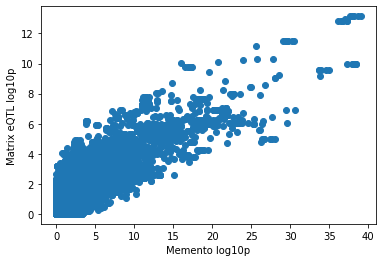

In [66]:
plt.scatter(-np.log10(merged['p.value']), -np.log10(merged['p-value']))
plt.xlabel('Memento log10p'); plt.ylabel('Matrix eQTL log10p')

In [15]:
mem_out.shape

(1016553, 6)

In [16]:
meq_out.shape

(843326, 6)

In [33]:
cts = ['B','T8', 'T4', 'NK', 'ncM', 'cM']

In [34]:
dfs = {}
pop = 'asian'
for ct in cts:
    dfs[ct] = pd.read_csv(('/data_volume/memento/lupus/full_analysis/memento/hits/{}_{}.csv'.format(pop, ct)))

In [35]:
heatmap = pd.DataFrame(index=cts, columns=cts)

In [36]:
import itertools

In [48]:
for c1, c2 in itertools.combinations(cts, 2):
    
    combined = dfs[c1].merge(dfs[c2], on=['SNP', 'gene'])
    corr = stats.pearsonr(combined['statistic_x'], combined['statistic_y'])[0]
    heatmap.loc[c1, c2] = corr
    heatmap.loc[c2, c1] = corr

In [49]:
heatmap

,B,T8,T4,NK,ncM,cM
B,NaN,0.434102,0.454726,0.327917,0.324042,0.335308
T8,0.434102,NaN,0.567092,0.46933,0.372621,0.359748
T4,0.454726,0.567092,NaN,0.433472,0.360829,0.378477
NK,0.327917,0.46933,0.433472,NaN,0.325552,0.328022
ncM,0.324042,0.372621,0.360829,0.325552,NaN,0.461685
cM,0.335308,0.359748,0.378477,0.328022,0.461685,NaN


<AxesSubplot:>

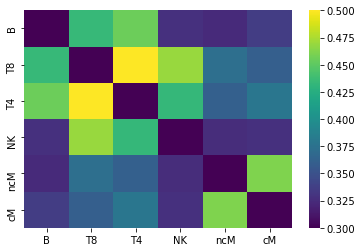

In [54]:
sns.heatmap(heatmap.fillna(0), cmap='viridis', vmin=0.3, vmax=0.5)

In [60]:
dfs = {}
pop = 'asian'
for ct in cts:
    dfs[ct] = pd.read_csv(('/data_volume/memento/lupus/full_analysis/mateqtl/outputs/{}_{}_all.csv'.format(pop, ct)), sep='\t')

In [61]:
heatmap = pd.DataFrame(index=cts, columns=cts)

In [62]:
import itertools

In [63]:
for c1, c2 in itertools.combinations(cts, 2):
    
    combined = dfs[c1].merge(dfs[c2], on=['SNP', 'gene'])
    corr = stats.pearsonr(combined['t-stat_x'], combined['t-stat_y'])[0]
    heatmap.loc[c1, c2] = corr
    heatmap.loc[c2, c1] = corr

In [64]:
heatmap

,B,T8,T4,NK,ncM,cM
B,NaN,0.472846,0.475286,0.368378,0.363941,0.384573
T8,0.472846,NaN,0.58416,0.44749,0.388629,0.397275
T4,0.475286,0.58416,NaN,0.412016,0.379356,0.453314
NK,0.368378,0.44749,0.412016,NaN,0.315573,0.323671
ncM,0.363941,0.388629,0.379356,0.315573,NaN,0.470275
cM,0.384573,0.397275,0.453314,0.323671,0.470275,NaN


<AxesSubplot:>

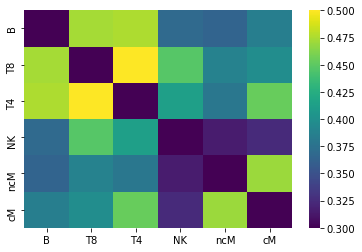

In [65]:
sns.heatmap(heatmap.fillna(0), cmap='viridis', vmin=0.3, vmax=0.5)